# Super resolution Part 2: generative modeling

---
Author:
- [@yueyingn](https://github.com/yueyingn) (Yueying Ni)

## Overview

In general, the mapping from low-res to high-res data is not deterministic due to the lack of information content. Therefore, SR is a generative process that learns the high-res / small-scale distribution conditioned on low-res / large-scale. We resort to generative models to carry out the super resolution task. 

In this tutorial, we use the [denoising diffusion probabilistic model](https://arxiv.org/abs/2006.11239) to super resolve the LR images. 

**Also see Carol's [diffusion model tutorial](https://github.com/florpi/iaifi-hackathon-2024-generative/blob/main/notebooks/tutorial_diffusion_models.ipynb) in case you would like to better understand better how they work!**


---

## Step 1: Preparing the training data

See Notebook1 for dataset generation.

We use galaxy image dataset as example here

In [1]:
%pylab inline
from dataset import *

Populating the interactive namespace from numpy and matplotlib


In [2]:
with h5py.File('/mnt/home/yni/ceph/Galaxy10_DECals.h5', 'r') as data:
    gal_images = np.array(data['images'])
    labels = np.array(data['ans'])
    
mask = (labels>=5)&(labels<=7) # select spiral galaxies
gal_images = gal_images[mask]
print ("shape of the data:",gal_images.shape)

gal_images = gal_images.astype(np.float32)
gal_images /= 255.0 # normalize the data
gal_images = np.moveaxis(gal_images,-1,1) # transform (N,H,W,C)->(N,C,H,W)
gal_images = torch.Tensor(gal_images) # convert to Tensor
print ("shape of the data:",gal_images.shape)

shape of the data: (6500, 256, 256, 3)
shape of the data: torch.Size([6500, 3, 256, 256])


In [3]:
ndim = 2
train_transforms = transforms.Compose([Flip(ndim),Permutate(ndim)]) # rotation of the image

# create the dataset
dataset = SupResDataset(gal_images, lr_size=32, hr_size=128, transform=train_transforms)

# split dataset for training and validation
train_set_size = int(len(dataset) * 0.9)
val_set_size = len(dataset) - train_set_size
train_dataset, val_dataset = random_split(dataset, [train_set_size, val_set_size])

# Create train and validation data loaders
BATCH_SIZE = 4
train_iterator = DataLoader(train_dataset,shuffle=True,batch_size=BATCH_SIZE)
val_iterator = DataLoader(val_dataset,batch_size=BATCH_SIZE)

In [4]:
iter_train = iter(train_iterator)

torch.Size([4, 3, 32, 32]) torch.Size([4, 3, 128, 128])
torch.Size([4, 3, 32, 32]) torch.Size([4, 3, 128, 128])


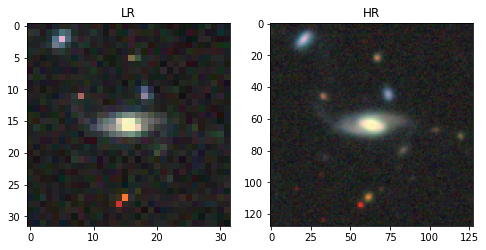

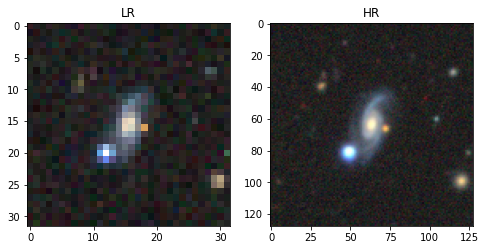

In [7]:
for n in range(2):
    lr_img, hr_img = next(iter_train)
    print (lr_img.shape,hr_img.shape)
    fig, ax = plt.subplots(ncols=2,figsize=(8,8))
    ax[0].imshow(torch.moveaxis(lr_img[0],0,-1))
    ax[0].set_title('LR')
    ax[1].imshow(torch.moveaxis(hr_img[0],0,-1))
    ax[1].set_title('HR')

## Step 2: Diffusion probabilistic model 

The framework we will use here is a simplified implementation of paper (https://arxiv.org/abs/2006.11239) that encapsulate:

### (1) The forward process: Noise Scheduler

**Key Takeaways**:
- The noise-levels/variances are pre-computed
- There are different types of variance schedules
- We can sample each timestep image independently (Sums of Gaussians is also Gaussian)
- No model/trainable parameters is needed in this forward step

### (2) The backward process: Score model (ResUNet)

**Key Takeaways**:
- We use a ResUNet model to predict the noise in the image
- The input is a noisy image and the LR conditioning, the ouput is the predicted noise in the image
- Because the parameters are shared accross time, we need to tell the network in which timestep we are
- The Timestep is encoded by the transformer Sinusoidal Embedding
- We output one single value (mean), as the variance is fixed

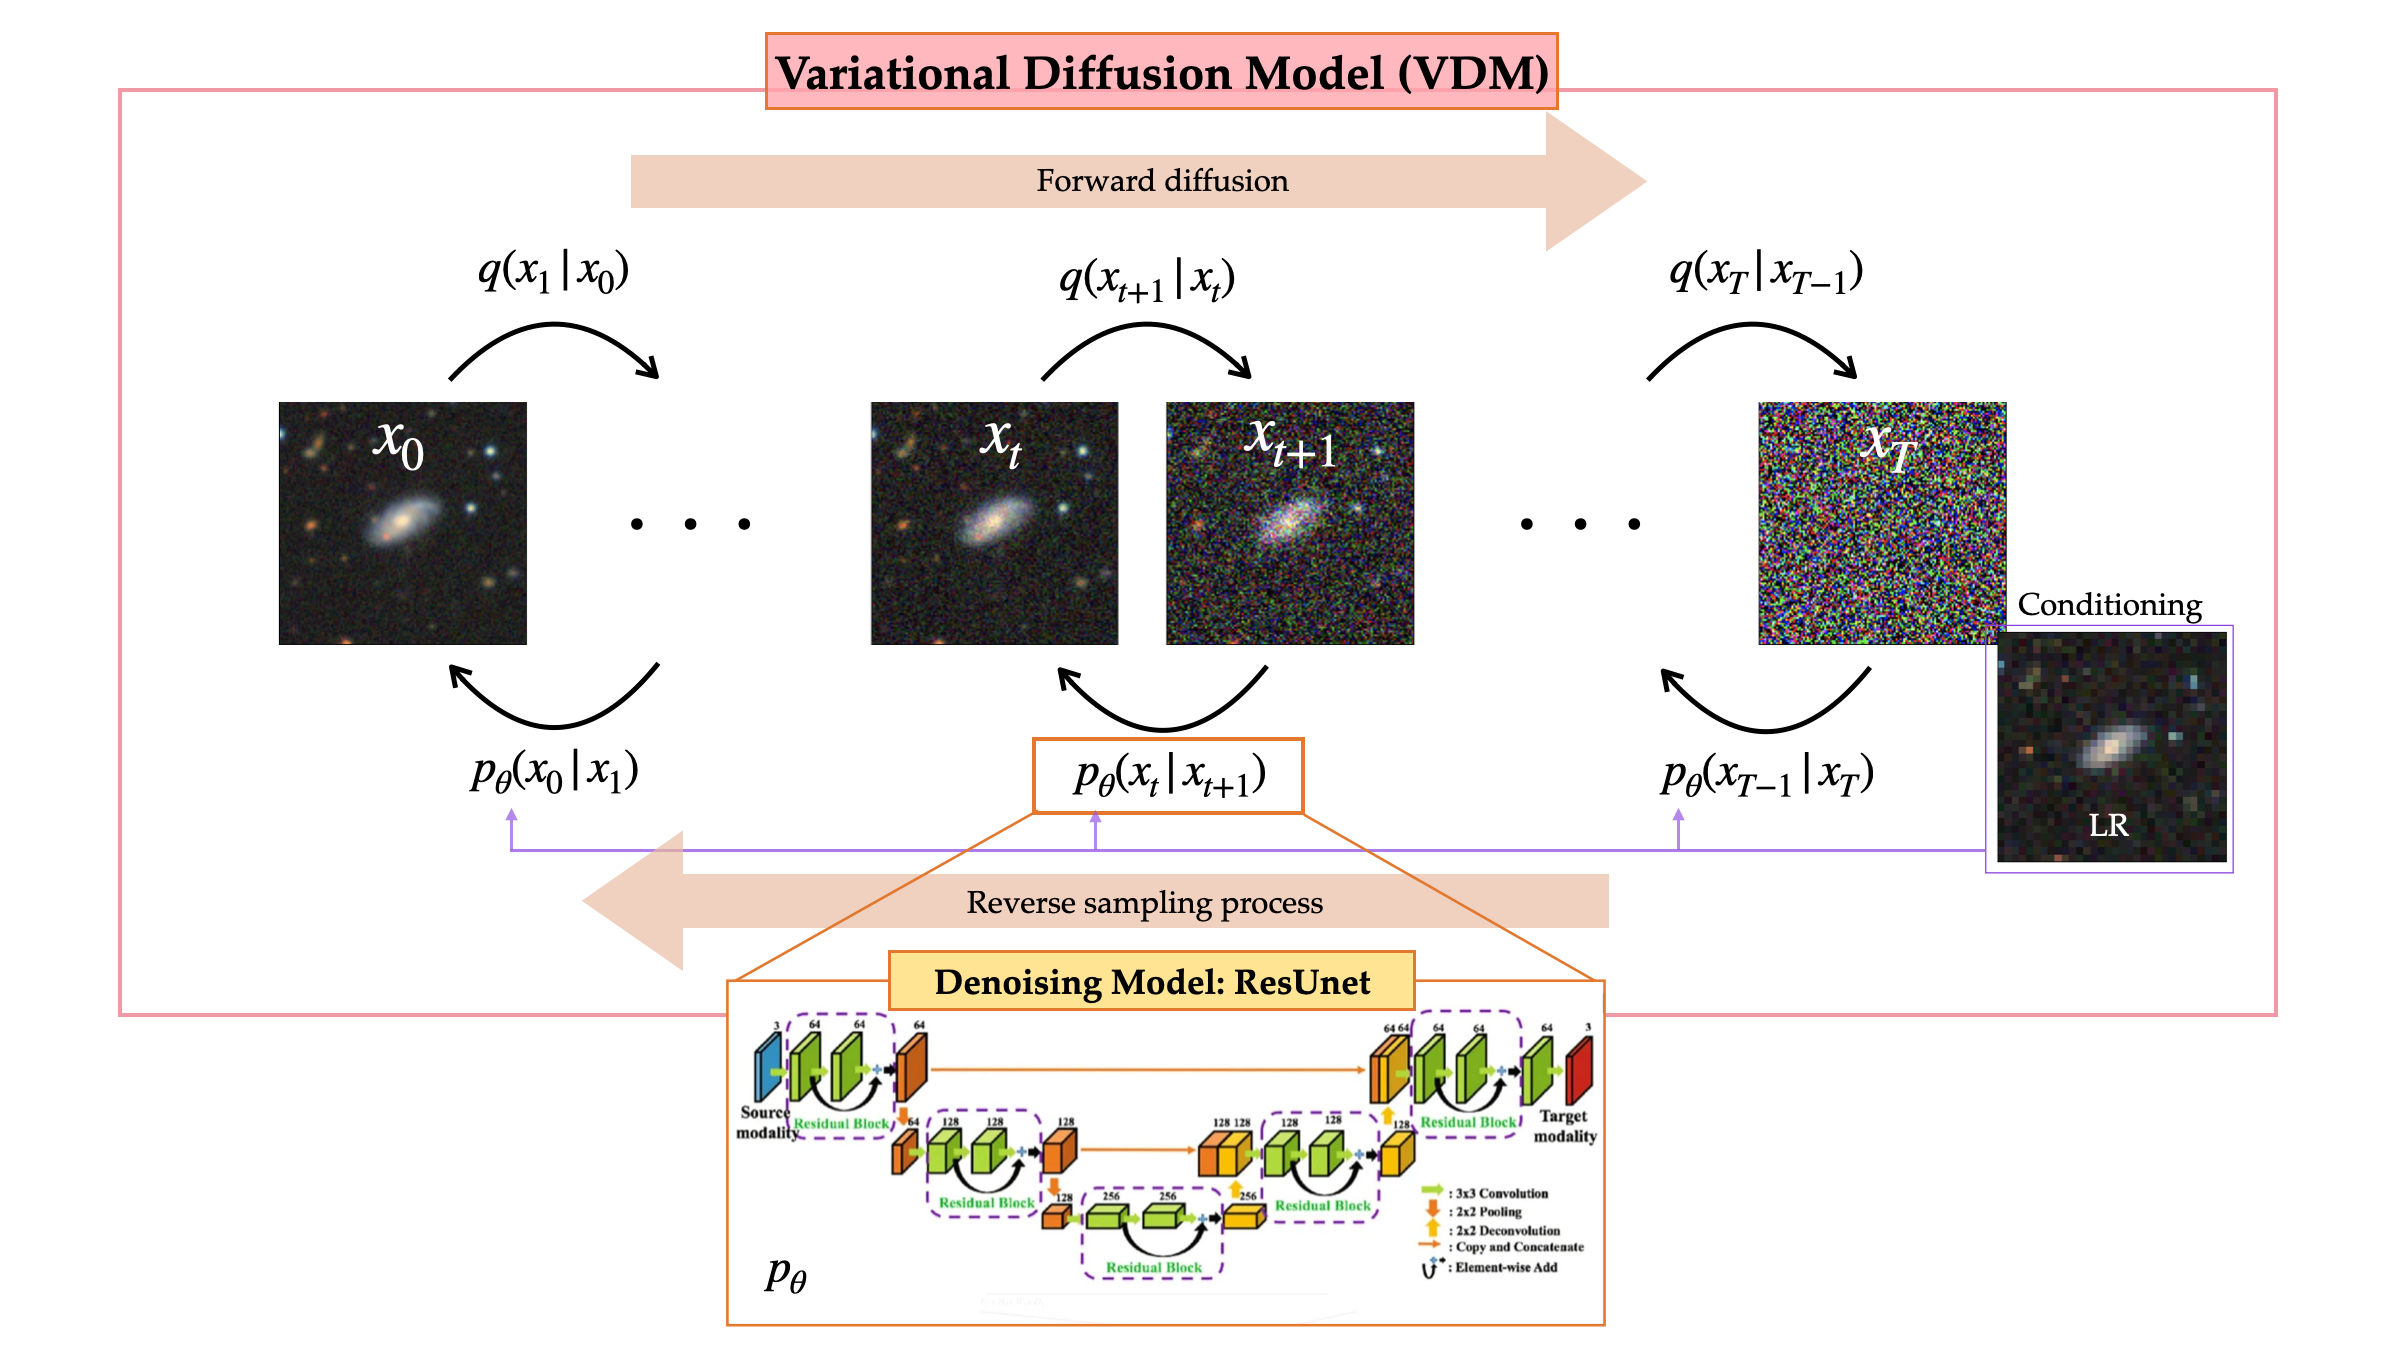

We build the VDM framework and also the score model in the following.

In [8]:
from torch import nn, autograd, Tensor
from typing import Optional, Tuple
from torch.distributions.normal import Normal
from tqdm import trange
from torch.special import expm1

### build the variational diffusion model (VDM)

In [9]:
def kl_std_normal(mean_squared, var):
    return 0.5 * (var + mean_squared - torch.log(var.clamp(min=1e-15)) - 1.0)

class FixedLinearSchedule(torch.nn.Module):
    def __init__(self, gamma_min, gamma_max):
        super().__init__()
        self.gamma_min = gamma_min
        self.gamma_max = gamma_max

    def forward(self, t):
        return self.gamma_min + (self.gamma_max - self.gamma_min) * t
    
class VDM(nn.Module):
    def __init__(
        self,
        score_model: nn.Module,
        gamma_min: float = -13.3,
        gamma_max: float = 13.3,
        image_shape: tuple = (1,128,128),
        data_noise: float = 1.0e-3,
    ):
        """Variational diffusion model, continuous time implementation of arxiv:2107.00630.

        Args:
            score_model (nn.Module): model used to denoise
            gamma_min (float, optional): minimum gamma value. Defaults to -13.3.
            gamma_max (float, optional): maximum gamma value. Defaults to 5.0.
            image_shape (Tuple[int], optional): image shape. Defaults to ( 3, 32, 32, ).
            data_noise (float, optional): noise in data, used for reconstruction loss. Defaults to 1.0e-3.

        """
        super().__init__()
        self.score_model = score_model
        self.image_shape = image_shape
        self.data_noise = data_noise
        self.gamma = FixedLinearSchedule(gamma_min, gamma_max)
        
    def variance_preserving_map(
        self, x: Tensor, times: Tensor, noise: Optional[Tensor] = None
    ) -> Tensor:
        """Add noise to data sample, in a variance preserving way Eq. 10 in arxiv:2107.00630

        Args:
            x (Tensor): data sample
            times (Tensor): time steps
            noise (Tensor, optional): noise to add. Defaults to None.

        Returns:
            Tensor: Noisy sample
        """
        with torch.enable_grad():  # Need gradient to compute loss even when evaluating
            times = times.view((times.shape[0],) + (1,) * (x.ndim-1))
            gamma_t = self.gamma(times)
        alpha = torch.sqrt(torch.sigmoid(-gamma_t))
        scale = torch.sqrt(torch.sigmoid(gamma_t))
        if noise is None:
            noise = torch.randn_like(x)
        return alpha * x + noise * scale, gamma_t

    def sample_times(
        self,
        batch_size: int,
        device: str,
    ) -> Tensor:
        """Sample diffusion times for batch, used for monte carlo estimates

        Args:
            batch_size (int): size of batch

        Returns:
            Tensor: times
        """
        t0 = np.random.uniform(0, 1 / batch_size)
        times = torch.arange(t0, 1.0, 1.0 / batch_size, device=device)
        
        return times

    def get_diffusion_loss(
        self,
        gamma_t: Tensor,
        times: Tensor,
        pred_noise: Tensor,
        noise: Tensor,
        bpd_factor: float,
    ) -> float:
        """get loss for diffusion process. Eq. 17 in arxiv:2107.00630

        Args:
            gamma_t (Tensor): gamma at time t
            times (Tensor): time steps
            pred_noise (Tensor): noise prediction
            noise (Tensor): noise added

        Returns:
            float: diffusion loss
        """
        gamma_grad = autograd.grad(  # gamma_grad shape: (B, )
            gamma_t,  # (B, )
            times,  # (B, )
            grad_outputs=torch.ones_like(gamma_t),
            create_graph=True,
            retain_graph=True,
        )[0]
        pred_loss = (
            ((pred_noise - noise) ** 2).flatten(start_dim=1).sum(axis=-1)
        )  # (B, )
        return bpd_factor * 0.5 * pred_loss * gamma_grad

    def get_latent_loss(
        self,
        x: Tensor,
        bpd_factor: float,
    ) -> float:
        """Latent loss to ensure the prior is truly Gaussian

        Args:
            x (Tensor): data sample

        Returns:
            float: latent loss
        """
        gamma_1 = self.gamma(torch.tensor([1.0], device=x.device))
        sigma_1_sq = torch.sigmoid(gamma_1)
        mean_sq = (1 - sigma_1_sq) * x**2
        return bpd_factor * kl_std_normal(mean_sq, sigma_1_sq).flatten(start_dim=1).sum(
            axis=-1
        )

    def get_reconstruction_loss(
        self,
        x: Tensor,
        bpd_factor: float,
    ):
        """Measure reconstruction error

        Args:
            x (Tensor): data sample

        Returns:
            float: reconstruction loss
        """
        noise_0 = torch.randn_like(x)
        times = torch.tensor([0.0], device=x.device)
        z_0, gamma_0 = self.variance_preserving_map(
            x,
            times=times,
            noise=noise_0,
        )
        # Generate a sample for z_0 -> closest to the data
        alpha_0 = torch.sqrt(torch.sigmoid(-gamma_0))
        z_0_rescaled = z_0 / alpha_0
        return bpd_factor * Normal(loc=z_0_rescaled, scale=self.data_noise).log_prob(
            x
        ).flatten(start_dim=1).sum(axis=-1)

    def get_loss(
        self,
        x: Tensor,
        conditioning: Optional[Tensor] = None,
        noise: Optional[Tensor] = None,
    ) -> float:
        """Get loss for diffusion model. Eq. 11 in arxiv:2107.00630

        Args:
            x (Tensor): data sample
            conditioning (Optional[Tensor], optional): conditioning. Defaults to None.
            noise (Optional[Tensor], optional): noise. Defaults to None.

        Returns:
            float: loss
        """
        bpd_factor = 1 / (np.prod(x.shape[1:]) * np.log(2))
        # Sample from q(x_t | x_0) with random t.
        times = self.sample_times(
            x.shape[0],
            device=x.device,
        ).requires_grad_(True)
        if noise is None:
            noise = torch.randn_like(x)
        x_t, gamma_t = self.variance_preserving_map(x=x, times=times, noise=noise)
        # Predict noise added
        pred_noise = self.score_model(
            x_t,
            conditioning=conditioning,
            g_t=gamma_t.squeeze(),
        )

        # *** Diffusion loss
        diffusion_loss = self.get_diffusion_loss(
            gamma_t=gamma_t,
            times=times,
            pred_noise=pred_noise,
            noise=noise,
            bpd_factor=bpd_factor,
        )

        # *** Latent loss: KL divergence from N(0, 1) to q(z_1 | x)
        latent_loss = self.get_latent_loss(
            x=x,
            bpd_factor=bpd_factor,
        )

        # *** Reconstruction loss:  - E_{q(z_0 | x)} [log p(x | z_0)].
        recons_loss = self.get_reconstruction_loss(
            x=x,
            bpd_factor=bpd_factor,
        )

        # *** Overall loss, Shape (B, ).
        loss = diffusion_loss + latent_loss + recons_loss

        metrics = {
            "elbo": loss.mean(),
            "diffusion_loss": diffusion_loss.mean(),
            "latent_loss": latent_loss.mean(),
            "reconstruction_loss": recons_loss.mean(),
        }
        return loss.mean(), metrics

    def alpha(self, gamma_t: Tensor) -> Tensor:
        """Eq. 4 arxiv:2107.00630

        Args:
            gamma_t (Tensor): gamma evaluated at t

        Returns:
            Tensor: alpha
        """
        return torch.sqrt(torch.sigmoid(-gamma_t))

    def sigma(self, gamma_t):
        """Eq. 3 arxiv:2107.00630

        Args:
            gamma_t (Tensor): gamma evaluated at t

        Returns:
            Tensor: sigma
        """
        return torch.sqrt(torch.sigmoid(gamma_t))

    def sample_zs_given_zt(
        self,
        zt: Tensor,
        conditioning: Tensor,
        t: Tensor,
        s: Tensor,
    ) -> Tensor:
        """Sample p(z_s|z_t, x) used for standard ancestral sampling. Eq. 34 in arxiv:2107.00630

        Args:
            z (Tensor): latent variable at time t
            conditioning (Tensor): conditioning for samples
            t (Tensor): time t
            s (Tensor): time s

        Returns:
            zs, samples for time s
        """
        gamma_t = self.gamma(t)
        gamma_s = self.gamma(s)
        c = -expm1(gamma_s - gamma_t)
        alpha_t = self.alpha(gamma_t)
        alpha_s = self.alpha(gamma_s)
        sigma_t = self.sigma(gamma_t)
        sigma_s = self.sigma(gamma_s)
        pred_noise = self.score_model(
            zt,
            conditioning=conditioning,
            g_t=gamma_t,
        )
        mean = alpha_s / alpha_t * (zt - c * sigma_t * pred_noise)
        scale = sigma_s * torch.sqrt(c)
        return mean + scale * torch.randn_like(zt)

    @torch.no_grad()
    def sample(
        self,
        conditioning: Tensor,
        batch_size: int,
        n_sampling_steps: int,
        device: str,
        z: Optional[Tensor] = None,
    ) -> Tensor:
        """Generate new samples given some conditioning vector

        Args:
            conditioning (Tensor): conditioning
            batch_size (int): number of samples in batch
            n_sampling_steps (int): number of sampling steps
            device (str, optional): device to run model. Defaults to "cpu".
            z (Optional[Tensor], optional): initial latent variable. Defaults to None.

        Returns:
            Tensor: generated sample
        """
        if z is None:
            z = torch.randn(
                (batch_size, *self.image_shape),
                device=device,
            )
        steps = torch.linspace(
            1.0,
            0.0,
            n_sampling_steps + 1,
            device=device,
        )
        for i in trange(n_sampling_steps, desc="sampling"):
            z = self.sample_zs_given_zt(
                zt=z,
                conditioning=conditioning,
                t=steps[i],
                s=steps[i + 1],
            )
        return z

### build the score model:  

In [10]:
@torch.no_grad()
def zero_init(module: torch.nn.Module) -> torch.nn.Module:
    """Sets to zero all the parameters of a module, and returns the module."""
    for p in module.parameters():
        torch.nn.init.zeros_(p.data)
    return module

def get_timestep_embedding(
    timesteps,
    embedding_dim: int,
    dtype=torch.float32,
    max_timescale=10000,
    min_timescale=1,
):
    # Scale timesteps by a factor of 1000
    timesteps *= 1000
    # Ensure timesteps is a 1-dimensional tensor
    assert timesteps.ndim == 1
    assert embedding_dim % 2 == 0

    num_timescales = embedding_dim // 2
    # Create a tensor of inverse timescales logarithmically spaced
    inv_timescales = torch.logspace(
        -np.log10(min_timescale),
        -np.log10(max_timescale),
        num_timescales,
        device=timesteps.device,
    )
    
    emb = timesteps.to(dtype)[:, None] * inv_timescales[None, :]  # Shape: (T, D/2)
    # Return the concatenation of sine and cosine of the embedding
    return torch.cat([emb.sin(), emb.cos()], dim=1)  # Shape: (T, D)

# the residual block class
class ResnetBlock(nn.Module):
    def __init__(self, ch_in, ch_out=None, condition_dim=None, dropout_prob=0.0, norm_groups=32):
        super().__init__()
        # Set output channels to input channels if not specified
        ch_out = ch_in if ch_out is None else ch_out

        # Store the channel and condition dimensions
        self.ch_in = ch_in
        self.ch_out = ch_out
        self.condition_dim = condition_dim

        # First part of the network
        self.net1 = nn.Sequential(
            nn.GroupNorm(num_groups=norm_groups, num_channels=ch_in),
            nn.SiLU(),
            nn.Conv2d(ch_in, ch_out, kernel_size=3, padding=1, padding_mode="circular"),
        )

        # Conditional projection if condition_dim is specified
        if condition_dim is not None:
            self.cond_proj = zero_init(nn.Linear(condition_dim, ch_out, bias=False))

        # Second part of the network
        self.net2 = nn.Sequential(
            nn.GroupNorm(num_groups=norm_groups, num_channels=ch_out),
            nn.SiLU(),
            *([nn.Dropout(dropout_prob)] * (dropout_prob > 0.0)),
            zero_init(nn.Conv2d(ch_out, ch_out, kernel_size=3, padding=1, padding_mode="circular")),
        )

        # Skip connection if input and output channels differ
        if ch_in != ch_out:
            self.skip_conv = nn.Conv2d(ch_in, ch_out, kernel_size=1)

    def forward(self, x, condition):
        # Apply the first part of the network
        h = self.net1(x)

        # Apply conditional projection if condition is provided
        if condition is not None:
            # Ensure condition shape matches the batch size
            assert condition.shape == (x.shape[0], self.condition_dim)
            condition = self.cond_proj(condition)
            # Expand condition to match the spatial dimensions of x
            condition = condition[:, :, None, None]  # 2D
            # Add the condition to the output of the first network part
            h = h + condition

        # Apply the second part of the network
        h = self.net2(h)

        # Apply skip connection if needed
        if x.shape[1] != self.ch_out:
            x = self.skip_conv(x)

        # Ensure the shapes of the input and the processed input match
        assert x.shape == h.shape
        # Return the sum of the input and the processed input
        return x + h

In [11]:
class UNetVDM(nn.Module):
    def __init__(
        self,
        scale_factor: int = 1,
        embedding_dim: int = 128,
        norm_groups: int = 32,
        dropout_prob: float = 0.1,
        input_channels: int = 1,
        conditioning_channels: int = 1,
        n_blocks: int = 32,
        gamma_min: float = -13.3,
        gamma_max: float = 13.3,
    ):
        super().__init__()
        
        self.scale_factor = scale_factor
        self.embedding_dim = embedding_dim
        self.gamma_min = gamma_min
        self.gamma_max = gamma_max
        
        resnet_params = dict(
            ch_in=embedding_dim,
            ch_out=embedding_dim,
            condition_dim=4 * embedding_dim,
            dropout_prob=dropout_prob,
            norm_groups=norm_groups,
        )
        
        self.embed_conditioning = nn.Sequential(
            nn.Linear(embedding_dim, embedding_dim * 4),
            nn.SiLU(),
            nn.Linear(embedding_dim * 4, embedding_dim * 4),
            nn.SiLU(),
        )
        
        total_input_ch = input_channels + conditioning_channels
        
        self.conv_in = nn.Conv2d(total_input_ch, embedding_dim, 3, padding=1)
        
        # Down path: n_blocks blocks with a resnet block and maybe attention.
        self.down_blocks = nn.ModuleList(
            ResnetBlock(**resnet_params)
            for _ in range(n_blocks)
        )

        self.mid_resnet_block_1 = ResnetBlock(**resnet_params)
        self.mid_resnet_block_2 = ResnetBlock(**resnet_params)

        # Up path: n_blocks+1 blocks with a resnet block and maybe attention.
        resnet_params["ch_in"] *= 2  # double input channels due to skip connections
        self.up_blocks = nn.ModuleList(
            ResnetBlock(**resnet_params)
            for _ in range(n_blocks + 1)
        )

        self.conv_out = nn.Sequential(
            nn.GroupNorm(num_groups=norm_groups, num_channels=embedding_dim),
            nn.SiLU(),
            zero_init(nn.Conv2d(embedding_dim, input_channels, 3, padding=1)),
        )

    def forward(
        self,
        z,
        g_t,
        conditioning=None,
    ):
        
        if conditioning is not None:
            if self.scale_factor>1:
                conditioning = torch.nn.functional.interpolate(conditioning, scale_factor=self.scale_factor,
                                             mode='bilinear', align_corners=False)
            z_concat = torch.concat(
                (z, conditioning),
                axis=1,
            )
        else:
            z_concat = z
        
        # Get gamma to shape (B, ).
        g_t = g_t.expand(z_concat.shape[0])  # assume shape () or (1,) or (B,)
        assert g_t.shape == (z_concat.shape[0],)
        # Rescale to [0, 1], but only approximately since gamma0 & gamma1 are not fixed.
        g_t = (g_t - self.gamma_min) / (self.gamma_max - self.gamma_min)
        t_embedding = get_timestep_embedding(g_t, self.embedding_dim)
        # We will condition on time embedding.
        cond = self.embed_conditioning(t_embedding)
        h = self.conv_in(z_concat)  # (B, embedding_dim, H, W)
        hs = []
        for down_block in self.down_blocks:  # n_blocks times
            hs.append(h)
            h = down_block(h, cond)
        hs.append(h)
        h = self.mid_resnet_block_1(h, cond)
        h = self.mid_resnet_block_2(h, cond)
        for up_block in self.up_blocks:  # n_blocks+1 times
            h = torch.cat([h, hs.pop()], dim=1)
            h = up_block(h, cond)
        prediction = self.conv_out(h)
        return prediction + z

### Initialize the model

In [12]:
score_model = UNetVDM(
    scale_factor = 4, # our SR task upscale the spatial resolution by 4 times
    embedding_dim=48, 
    norm_groups = 8,
    n_blocks = 4,
    input_channels = 3, # For galaxy images with 3 channels (RGB)
    conditioning_channels = 3,
)

lr_img, hr_img = next(iter_train)

vdm = VDM(score_model = score_model, image_shape = hr_img.shape[1:])

**illustration of the forward process**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


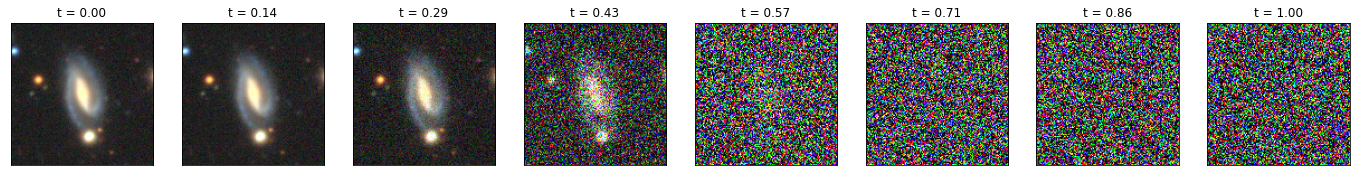

In [13]:
# Adding Noise
times = torch.Tensor(np.linspace(0.,1., 8), )

fig, ax = plt.subplots(ncols=len(times),figsize=(24,4))
for i, time in enumerate(times):
    noisy_sample, _ = vdm.variance_preserving_map(hr_img[0], torch.Tensor([time]))
    x = noisy_sample.squeeze().cpu().numpy()
    x = np.moveaxis(x,0,-1)
    ax[i].imshow(x)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_title(f't = {time:.2f}')
    
# fig.savefig('gal-diffusion.png',dpi=100,bbox_inches='tight')

**calculate the loss for backward process**

In [14]:
loss,metric = vdm.get_loss(x=hr_img, conditioning=lr_img)
print ("total loss = ",loss.item())
print ("diffusion loss =",metric['diffusion_loss'].item())

total loss =  12.752388000488281
diffusion loss = 5.318664073944092


## Step3: Train the model 

In [15]:
from torch.optim import Adam, AdamW, lr_scheduler

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print (device)

# put models on gpu
score_model = score_model.to(device)
vdm = vdm.to(device)

cuda


In [17]:
optimizer = AdamW(vdm.parameters(), lr=1e-4, weight_decay=1.0e-5)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

sampling: 100%|██████████| 250/250 [00:03<00:00, 73.73it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 0 | Diffusion_loss =8.8


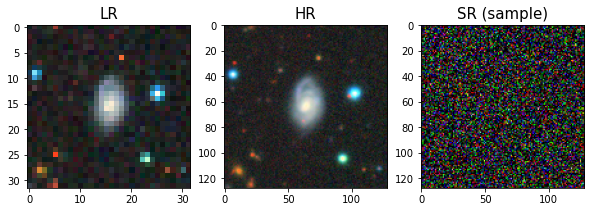

sampling: 100%|██████████| 250/250 [00:03<00:00, 73.45it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 3 | Diffusion_loss =2.8


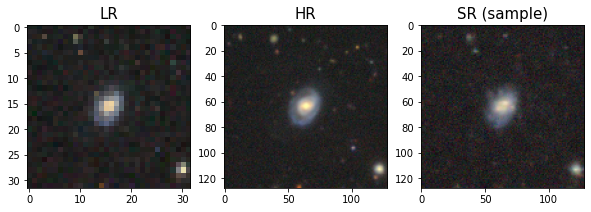

sampling: 100%|██████████| 250/250 [00:03<00:00, 73.44it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 6 | Diffusion_loss =4.2


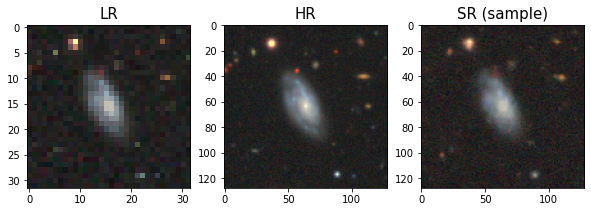

sampling: 100%|██████████| 250/250 [00:03<00:00, 73.45it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 9 | Diffusion_loss =5.5


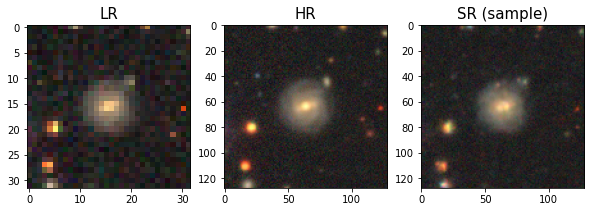

sampling: 100%|██████████| 250/250 [00:03<00:00, 73.46it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 12 | Diffusion_loss =3.9


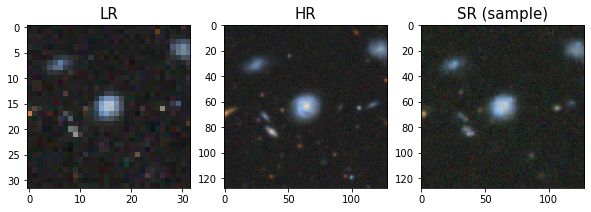

sampling: 100%|██████████| 250/250 [00:03<00:00, 73.46it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 15 | Diffusion_loss =3.4


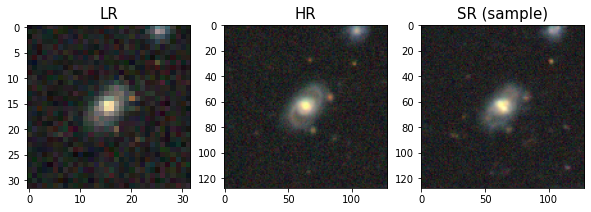

sampling: 100%|██████████| 250/250 [00:03<00:00, 73.45it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 18 | Diffusion_loss =2.9


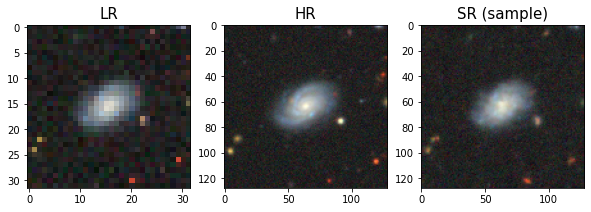

sampling: 100%|██████████| 250/250 [00:03<00:00, 73.46it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 21 | Diffusion_loss =4.5


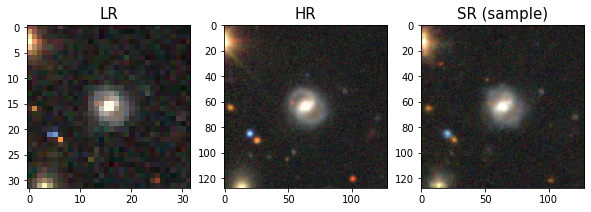

sampling: 100%|██████████| 250/250 [00:03<00:00, 73.45it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 24 | Diffusion_loss =5.8


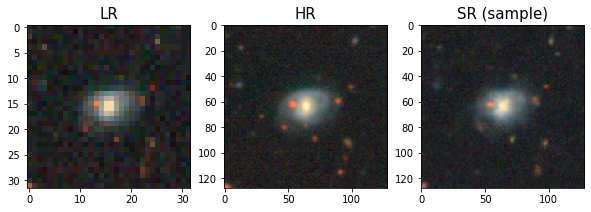

sampling: 100%|██████████| 250/250 [00:03<00:00, 73.47it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 27 | Diffusion_loss =3.2


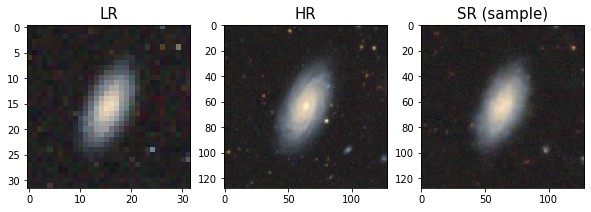

In [18]:
epochs = 30 # should try more!

for epoch in range(epochs):
    for step, (lr_img, hr_img) in enumerate(train_iterator):
        
        lr_img, hr_img = lr_img.to(device), hr_img.to(device)
        optimizer.zero_grad()
        loss, metric = vdm.get_loss(x=hr_img, conditioning=lr_img)
        loss.backward()
        optimizer.step()
        
        if epoch % 3 == 0 and step == 0:
            sample = vdm.sample(
                    conditioning=lr_img,
                    batch_size=len(lr_img),
                    n_sampling_steps=250,
                    device=device)
            
            print(f"Epoch {epoch} | Diffusion_loss =%.1f"%(metric['diffusion_loss'].item()))
            fig, ax = plt.subplots(ncols=3,figsize=(10,3))
            labels = ['LR','HR','SR (sample)']
            for i,ds in enumerate([lr_img[0], hr_img[0], sample[0]]):
                x = ds.squeeze().cpu().numpy()
                x = np.moveaxis(x,0,-1)
                ax[i].imshow(x)
                ax[i].set_title(labels[i],fontsize=15)
            plt.show()

We train the model for a few epochs and it already looks not bad!

## get multiple SR samples from the trained model

In [34]:
Nsamples = 8

iter_val = iter(val_iterator)
lr_img, hr_img = next(iter_val)
conditioning = lr_img[0:1].repeat_interleave(Nsamples,dim=0)

In [36]:
sample = vdm.sample(
    conditioning=conditioning.to(device),
    batch_size=Nsamples,
    n_sampling_steps=250,
    device=device,    
)

sampling: 100%|██████████| 250/250 [00:05<00:00, 42.16it/s]


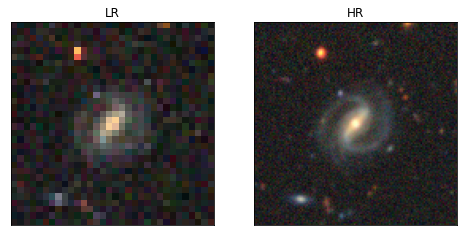

In [42]:
fig, ax = plt.subplots(ncols=2,figsize=(8,4))
labels = ['LR','HR']
for i,d in enumerate([lr_img[0],hr_img[0]]):
    x = d.squeeze().cpu().numpy()
    x = np.moveaxis(x,0,-1)
    ax[i].imshow(x)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_title(labels[i])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


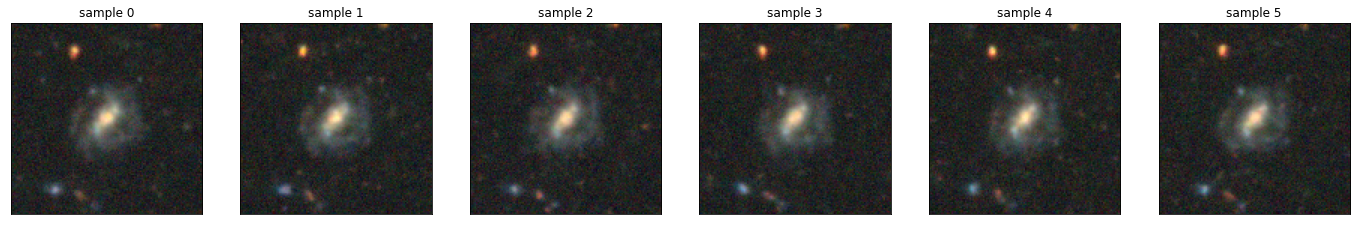

In [43]:
fig, ax = plt.subplots(ncols=6,figsize=(24,4))

for i in range(6):
    x = sample[i].squeeze().cpu().numpy()
    x = np.moveaxis(x,0,-1)
    ax[i].imshow(x)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_title('sample %d'%i)